In [1]:

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch
if torch.cuda.is_available():
        device = torch.device('cuda')

print(device)
import numpy as np

import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib
import sys

import random
from sklearn.model_selection import KFold
# 캐싱된 모듈 삭제
if 'models' in sys.modules:
    del sys.modules['models']
if 'Segdataset' in sys.modules:
    del sys.modules['Segdataset']
if 'utils' in sys.modules:
    del sys.modules['utils']
from models import CNN , RNN
from Segdataset import SegDataset,read_train_file_list
from torch.utils.data import DataLoader

cuda


In [2]:
class Args:
    def __init__(self):
        self.data_root = '/workspace/dataset/tess_datasets/train/train_data'
        self.save_root = 'checkpoints/RNN'
        self.epoch = 50
        self.lr = 1e-5
        self.batch_size = 32
        self.num_workers = 8
        self.random_seed = 1
        self.n_mfcc = 16
        self.n_splits = 5
        self.model_kind = 'rnn'

opt = Args()


In [3]:
def main():
    print("Training by RNN")

    # 저장 디렉토리 없으면 생성
    if not os.path.exists(opt.save_root):
        os.makedirs(opt.save_root)
        print('Created directory:', opt.save_root)

    # 데이터셋 로딩
    mfcc_list, emotion_list = read_train_file_list(root=opt.data_root, n_mfcc=opt.n_mfcc)

    # KFold cross-validation
    kf = KFold(n_splits=opt.n_splits, shuffle=True, random_state=opt.random_seed)

    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    print(f"Using device: {device}")

    all_train_epoch_loss = []
    all_test_epoch_loss = []
    all_test_epoch_accuracy_emotion = []

    return kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [4]:
def plot_fold_performance(train_losses, val_losses, val_accuracies, fold):
    # Fold별로 그래프를 그리기 (Colab에서 바로 확인 가능하도록)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [5]:
def train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion):
    for fold, (train_idx, val_idx) in enumerate(kf.split(mfcc_list)):
        print(f"Fold {fold + 1}/{opt.n_splits}")

        # 모델을 fold마다 초기화
        model = RNN().to(device)

        # 학습/검증 데이터로 쪼개기
        train_mfcc = [mfcc_list[i] for i in train_idx]
        train_emotion = [emotion_list[i] for i in train_idx]
        val_mfcc = [mfcc_list[i] for i in val_idx]
        val_emotion = [emotion_list[i] for i in val_idx]

        train_set = SegDataset(train_mfcc, train_emotion)
        val_set = SegDataset(val_mfcc, val_emotion)

        # Create dataloaders
        train_loader = DataLoader(train_set, batch_size=opt.batch_size, shuffle=True, drop_last=True, num_workers=opt.num_workers)
        val_loader = DataLoader(val_set, batch_size=opt.batch_size, shuffle=False, drop_last=True, num_workers=opt.num_workers)

        # 각 fold에 따라 pos_weight 동적으로 설정
        num_pos = sum(em == 1 for em in train_emotion)
        num_neg = sum(em == 0 for em in train_emotion)
        pos_weight = torch.tensor([num_neg / num_pos]).to(device) if num_pos > 0 else torch.tensor([1.0]).to(device)

        # loss and optimizer 선언
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
        optimizer = optim.Adam(model.parameters(), lr=opt.lr)

        # 현재 폴드 값들 저장
        train_losses = []
        val_losses = []
        val_accuracies = []

        best_val_loss = float('inf')
        best_epoch = 0

        for epo in range(opt.epoch):
            model.train()
            train_loss = 0

            for index, (mfcc, emotion) in enumerate(train_loader):
                mfcc, emotion = mfcc.to(device), emotion.to(device)
                optimizer.zero_grad()
                output_emotion = model(mfcc)

                emotion = emotion.float()
                loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # 검증
            model.eval()
            val_loss = 0
            correct_emotion = 0
            total = 0
            with torch.no_grad():
                for mfcc, emotion in val_loader:
                    mfcc, emotion = mfcc.to(device), emotion.to(device)
                    output_emotion = model(mfcc)
                    emotion = emotion.float()

                    loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                    val_loss += loss.item()

                    predicted_emotion = (torch.sigmoid(output_emotion[:, 0]) > 0.56).float()
                    correct_emotion += (predicted_emotion == emotion).sum().item()
                    total += emotion.size(0)

            val_accuracy = correct_emotion / total
            print(f"Fold {fold + 1} | Epoch {epo} | Train Loss: {train_loss / len(train_loader)} | Val Loss: {val_loss / len(val_loader)} | Val Accuracy: {val_accuracy}")

            # 모델 저장
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epo
                torch.save(model.state_dict(), os.path.join(opt.save_root, f'fold_{fold + 1}_best_epoch.pth'))

            # Track the training and validation losses and accuracies for plotting later
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_accuracy)

        print(f"Fold{fold+1} best epoch : {best_epoch} ")

        all_train_epoch_loss.append(train_losses)
        all_test_epoch_loss.append(val_losses)
        all_test_epoch_accuracy_emotion.append(val_accuracies)

        plot_fold_performance(train_losses, val_losses, val_accuracies, fold)

    return all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


Training by RNN
Using device: cuda
Fold 1/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 1 | Epoch 0 | Train Loss: 0.6392106083886964 | Val Loss: 0.6018897678170886 | Val Accuracy: 0.6205357142857143
Fold 1 | Epoch 1 | Train Loss: 0.6390004243169513 | Val Loss: 0.6017852638448987 | Val Accuracy: 0.6205357142857143
Fold 1 | Epoch 2 | Train Loss: 0.6387943966048104 | Val Loss: 0.6016786141054971 | Val Accuracy: 0.6205357142857143
Fold 1 | Epoch 3 | Train Loss: 0.638573523078646 | Val Loss: 0.6015744166714805 | Val Accuracy: 0.6205357142857143
Fold 1 | Epoch 4 | Train Loss: 0.6383417621254921 | Val Loss: 0.6014546624251774 | Val Accuracy: 0.6205357142857143
Fold 1 | Epoch 5 | Train Loss: 0.6380832567811012 | Val Loss: 0.6013266061033521 | Val Accuracy: 0.6205357142857143
Fold 1 | Epoch 6 | Train Loss: 0.6377976941210883 | Val Loss: 0.6011814858232226 | Val Accuracy: 0.6205357142857143
Fold 1 | Epoch 7 | Train Loss: 0.6374769455620221 | Val Loss: 0.60102046813283

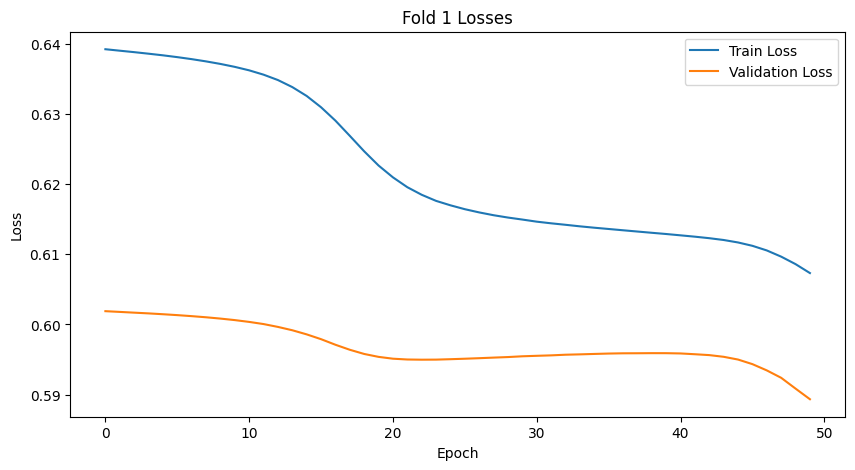

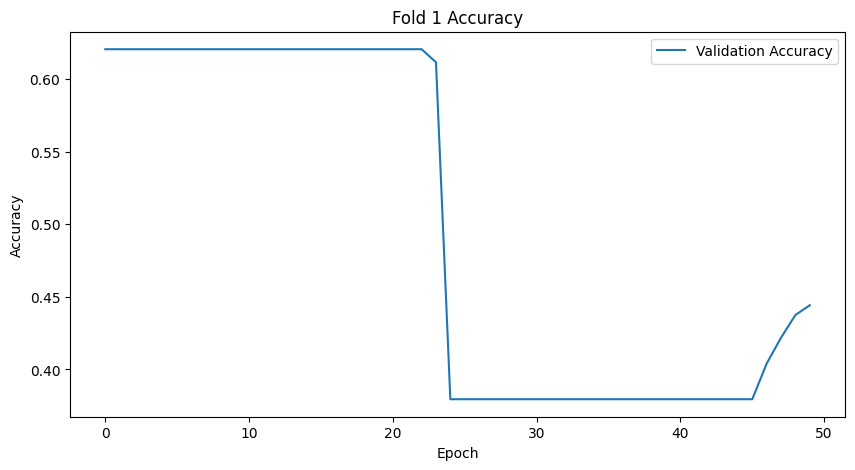

Fold 2/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 2 | Epoch 0 | Train Loss: 0.6175941186291831 | Val Loss: 0.6320055893489293 | Val Accuracy: 0.5535714285714286
Fold 2 | Epoch 1 | Train Loss: 0.6173016114958695 | Val Loss: 0.631671837397984 | Val Accuracy: 0.5535714285714286
Fold 2 | Epoch 2 | Train Loss: 0.6170122314776693 | Val Loss: 0.6313221880367824 | Val Accuracy: 0.5535714285714286
Fold 2 | Epoch 3 | Train Loss: 0.6167186189975057 | Val Loss: 0.6309362862791333 | Val Accuracy: 0.5535714285714286
Fold 2 | Epoch 4 | Train Loss: 0.616388697709356 | Val Loss: 0.6305577499525887 | Val Accuracy: 0.5535714285714286
Fold 2 | Epoch 5 | Train Loss: 0.6160350782530648 | Val Loss: 0.6301107023443494 | Val Accuracy: 0.5535714285714286
Fold 2 | Epoch 6 | Train Loss: 0.6156345510057041 | Val Loss: 0.6295891744749886 | Val Accuracy: 0.5535714285714286
Fold 2 | Epoch 7 | Train Loss: 0.6151658871344158 | Val Loss: 0.6290147049086434 | Val Accuracy: 0.553571428571428

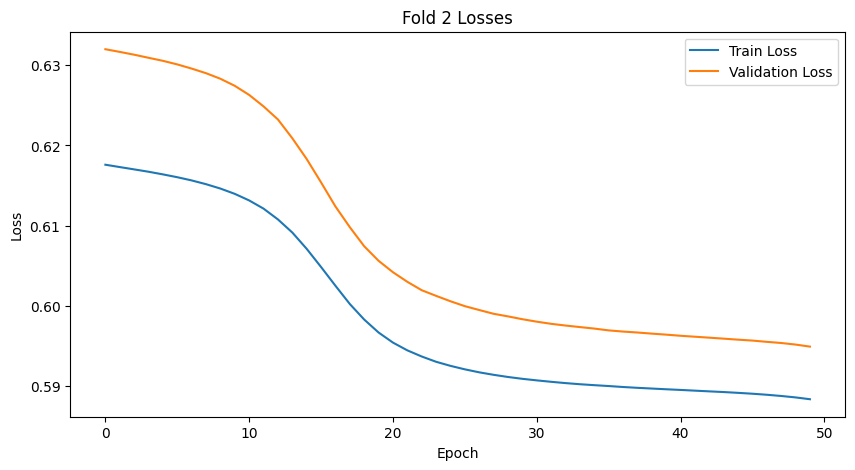

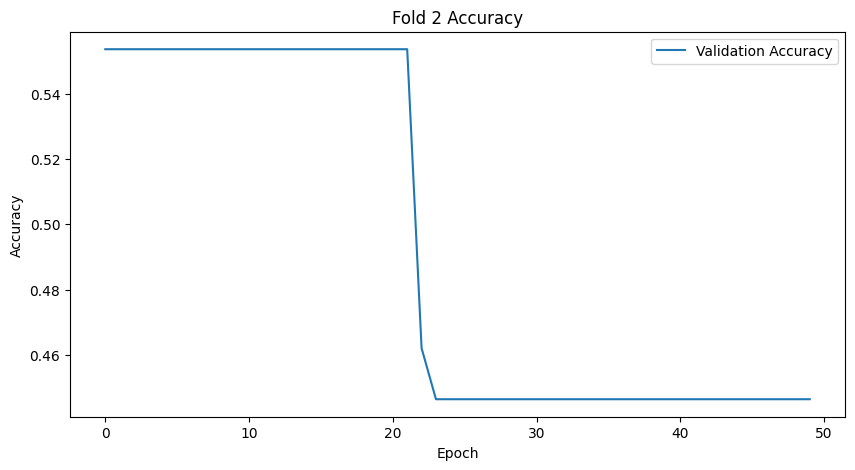

Fold 3/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 3 | Epoch 0 | Train Loss: 0.6033768291984286 | Val Loss: 0.631664093051638 | Val Accuracy: 0.5334821428571429
Fold 3 | Epoch 1 | Train Loss: 0.6031258404254913 | Val Loss: 0.6313111824648721 | Val Accuracy: 0.5334821428571429
Fold 3 | Epoch 2 | Train Loss: 0.6028714148061616 | Val Loss: 0.6309285078729902 | Val Accuracy: 0.5334821428571429
Fold 3 | Epoch 3 | Train Loss: 0.6026091357426984 | Val Loss: 0.6305391916206905 | Val Accuracy: 0.5334821428571429
Fold 3 | Epoch 4 | Train Loss: 0.6023399537163121 | Val Loss: 0.630148925951549 | Val Accuracy: 0.5334821428571429
Fold 3 | Epoch 5 | Train Loss: 0.6020599656871387 | Val Loss: 0.6297146039349693 | Val Accuracy: 0.5334821428571429
Fold 3 | Epoch 6 | Train Loss: 0.6017585045525006 | Val Loss: 0.629268935748509 | Val Accuracy: 0.5334821428571429
Fold 3 | Epoch 7 | Train Loss: 0.6014340477330344 | Val Loss: 0.6287959047726223 | Val Accuracy: 0.5334821428571429

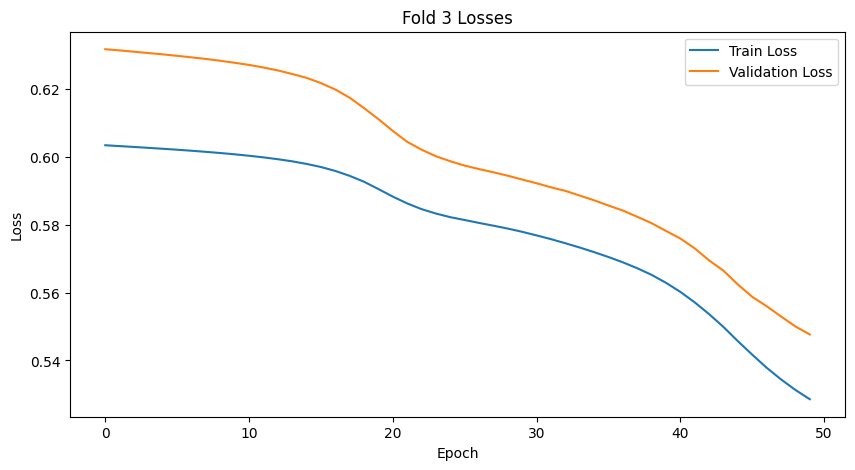

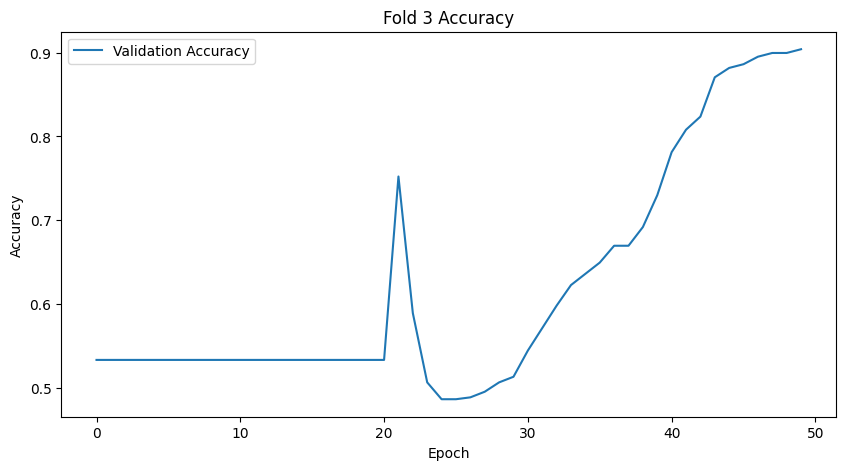

Fold 4/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 4 | Epoch 0 | Train Loss: 0.6206423358193466 | Val Loss: 0.6240430900028774 | Val Accuracy: 0.5669642857142857
Fold 4 | Epoch 1 | Train Loss: 0.6203817735825267 | Val Loss: 0.6237771170479911 | Val Accuracy: 0.5669642857142857
Fold 4 | Epoch 2 | Train Loss: 0.6201214428458895 | Val Loss: 0.6234901249408722 | Val Accuracy: 0.5669642857142857
Fold 4 | Epoch 3 | Train Loss: 0.6198525641645704 | Val Loss: 0.6232031115463802 | Val Accuracy: 0.5669642857142857
Fold 4 | Epoch 4 | Train Loss: 0.6195789160473006 | Val Loss: 0.6229204535484314 | Val Accuracy: 0.5669642857142857
Fold 4 | Epoch 5 | Train Loss: 0.6192992553114891 | Val Loss: 0.6226189306804112 | Val Accuracy: 0.5669642857142857
Fold 4 | Epoch 6 | Train Loss: 0.6190059365970748 | Val Loss: 0.6222988069057465 | Val Accuracy: 0.5669642857142857
Fold 4 | Epoch 7 | Train Loss: 0.6186903949294772 | Val Loss: 0.6219534916537148 | Val Accuracy: 0.5669642857142

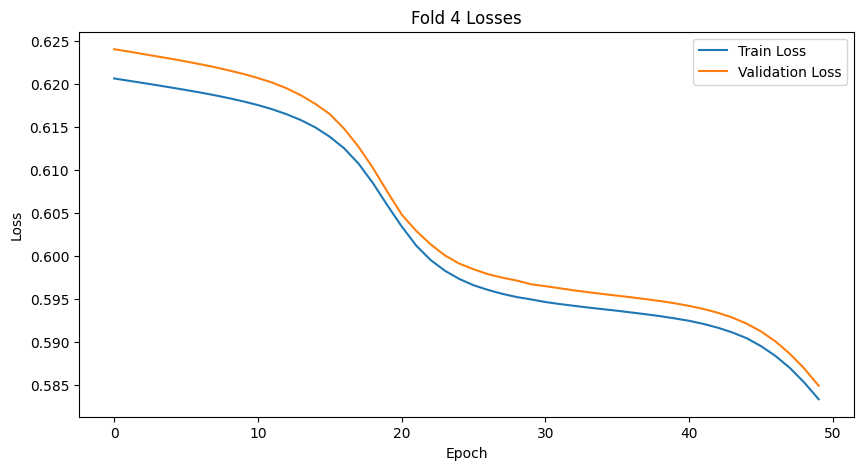

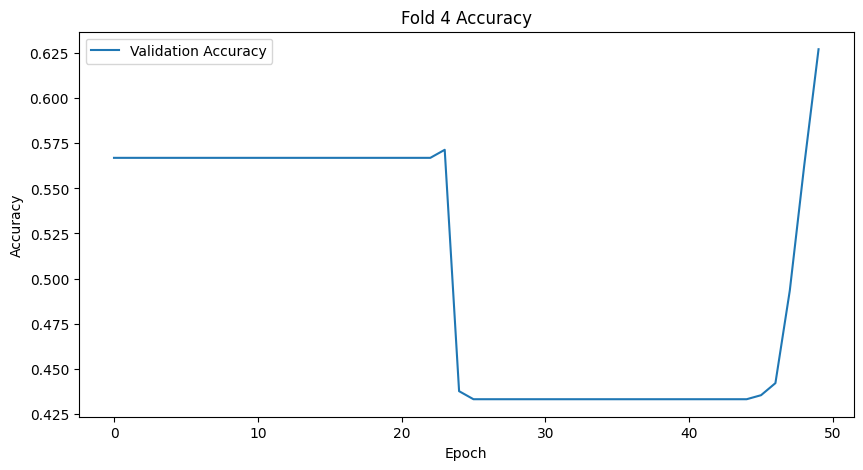

Fold 5/5
Dataset loaded with 1792 samples.
Dataset loaded with 448 samples.
Fold 5 | Epoch 0 | Train Loss: 0.6246429873364312 | Val Loss: 0.6159670821258 | Val Accuracy: 0.5825892857142857
Fold 5 | Epoch 1 | Train Loss: 0.6244088177170072 | Val Loss: 0.6157582231930324 | Val Accuracy: 0.5825892857142857
Fold 5 | Epoch 2 | Train Loss: 0.6241715550422668 | Val Loss: 0.6155456985746112 | Val Accuracy: 0.5825892857142857
Fold 5 | Epoch 3 | Train Loss: 0.6239275676863534 | Val Loss: 0.615329555102757 | Val Accuracy: 0.5825892857142857
Fold 5 | Epoch 4 | Train Loss: 0.6236717706280095 | Val Loss: 0.6150929033756256 | Val Accuracy: 0.5825892857142857
Fold 5 | Epoch 5 | Train Loss: 0.6233983923281942 | Val Loss: 0.6148315327508109 | Val Accuracy: 0.5825892857142857
Fold 5 | Epoch 6 | Train Loss: 0.6230951877576965 | Val Loss: 0.6145566744463784 | Val Accuracy: 0.5825892857142857
Fold 5 | Epoch 7 | Train Loss: 0.6227616273931095 | Val Loss: 0.6142505790506091 | Val Accuracy: 0.5825892857142857


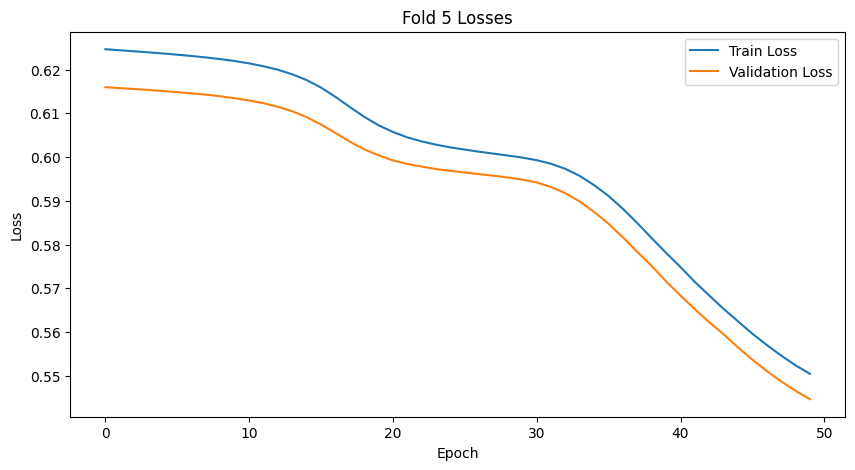

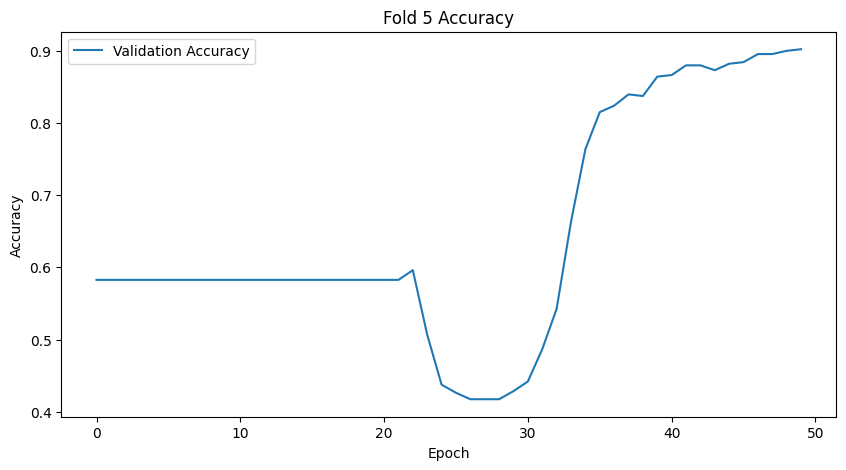

In [6]:
if __name__ == '__main__':
    kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion = main()
    train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion)